In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import G, M_sun
from scipy.interpolate import interp1d
from matplotlib import colors 
from scipy.integrate import simps
import astropy.units as u
import tqdm
import numpy as np
import warnings
import sys
sys.path.append('../my_funcs/')
from pipeline_main import pipeline
#from pipeline_stress import _fill_2Dhist
from pipeline_1D import *
from pipeline_stress import _fill_2Dhist


# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

# This notebook is made by exracting values over both φ and z so the final plots is 2 dimensional

# How to connect the knowledge of the three stresses, angular momentum transport and the α-parameter
### Form Suziki et al. (2016) Appendix A Eq. A.3 and A.4:
### $$\rho\alpha_{r\phi}c_s^2 = \rho v_r\delta v_\phi - \frac{B_rB_\phi}{4\pi} + \frac{(\nabla\Phi)_\phi(\nabla\Phi)_r}{4\pi G}$$
### $$\rho\alpha_{\phi z}c_s^2 = \rho v_z\delta v_\phi - \frac{B_zB_\phi}{4\pi} + \frac{(\nabla\Phi)_\phi(\nabla\Phi)_z}{4\pi G}$$
### $$v_\phi=r\Omega + \delta v_\phi,\quad\quad *C_s^2 = \frac{P}{\rho}$$
# $$\Leftrightarrow$$
### $$\alpha_{r\phi} (c_s^2)_{mid}= \int dz \left[v_r\delta v_\phi - \frac{B_rB_\phi}{4\pi\rho} + \frac{(\nabla\Phi)_\phi(\nabla\Phi)_r}{4\pi G\rho}\right]$$
### $$\alpha_{\phi z} (c_s^2)_{mid}= \int dz \left[v_z\delta v_\phi - \frac{B_zB_\phi}{4\pi\rho} + \frac{(\nabla\Phi)_\phi(\nabla\Phi)_z}{4\pi G\rho}\right]$$
### *$C_s$ could also be defined from the temperature as in Suzuki
### I only use the midplane sound speed since ρ has to be integrated over $z$ to become $Σ$

Initialising patch data


100%|██████████| 4165/4165 [00:03<00:00, 1253.91it/s]


Converged mean angular momentum vector after 0 iteration(s)
Looping through patches, assigning azimuthal velocities to all cells and extracing them within given cylindrical coordiantes


100%|██████████| 4165/4165 [00:00<00:00, 9140.45it/s] 


Disk size: 17.9 au
Transforming old z-coordinate into mean angular momentum vector


100%|██████████| 4165/4165 [00:00<00:00, 5131.39it/s]


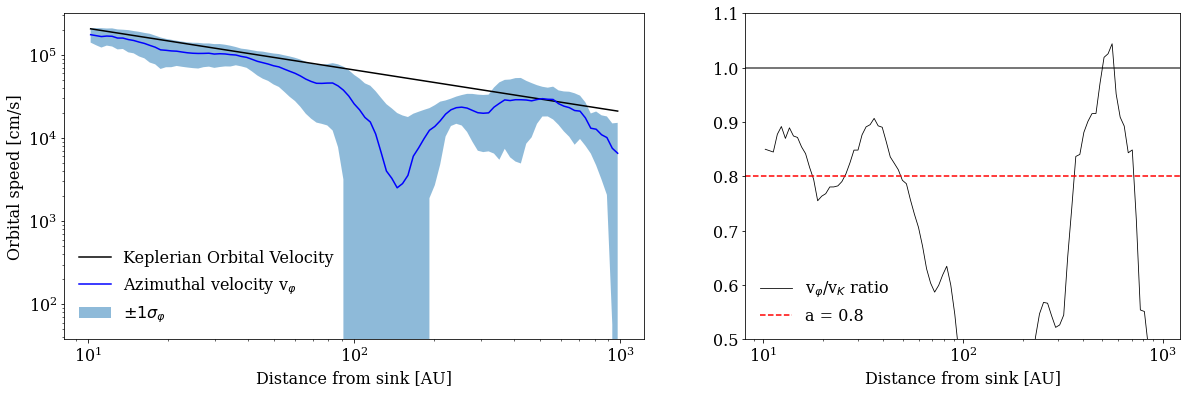

In [12]:
data = pipeline(snap = 357, run = 'my_core_13lacc', sink_id=13)
data.recalc_L(verbose = 1); 
data.calc_disksize(plot = True); data.calc_trans_xyz()

In [13]:
data.to_1D(plot = False, r_in=5, r_out = 1000, Nr = 200)

Looping through patches to extract densities and heights
Fitting surface density and scaleheight in each radial bin


100%|██████████| 199/199 [00:03<00:00, 64.17it/s]


In [14]:
data.get_1D_param(cs=True)

Calculating azimuthal and angular velocities


100%|██████████| 1959/1959 [00:03<00:00, 504.83it/s]


Calculating isothermal sound speed c_s = (P/ρ)^0.5
The adiabatic index γ is NOT accounted for


100%|██████████| 1959/1959 [00:04<00:00, 442.35it/s]

Σ = g/cm2
φ = rad
H = au
vφ = cm/s
Ω = 1/s
cs = cm/s
Q = dimensionless
B = Gauss


In [15]:
cs_func = interp1d(data.r_1D * data.au_length, data.cs_1D[:,0], fill_value='extrapolate')

In [16]:
#def get_alpha(data, radius = 90, Nh = 100, N_phi = 200, refine_grid = 2, shell_Δpct = 0.01, plot = True, verbose = 1):
radius = 20; Nh = 100; N_phi = 200; refine_grid = 2; shell_Δpct = 0.05; plot = True; verbose = 1

Nr = int(2 * Nh); N_phi_v = N_phi // 2; height = 15
G_cgs = G.to('cm**3 / (g * s**2)').value
radius /= data.au_length; height /= data.au_length; 

# The shell is given in terms of the radius; Default is +- 1% -> 0.01
shell_Δ = np.maximum(shell_Δpct * radius, 0.5**(data.lmax))
selection_radius = np.sqrt(radius**2 + height**2) * 2

pp = [p for p in data.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
w= np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]

if verbose != 0: print(f'Using {len(sorted_patches)} patches to retrive angular momentum change')


#__________________________________________________EXTRACTING KNOWLEDGE OF THE RADIAL PART OF THE STRESS___________________________________________________

extracted_values =  {key: [] for key in range(7)}
if verbose != 0: print('Calculating radial part')
for p in sorted_patches:
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [ n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
    if len(leafs) == 8: continue

    to_extract = (p.cyl_R > radius - shell_Δ) & (p.cyl_R <  radius + shell_Δ)
    p.B = np.concatenate([p.var(f'b'+axis)[None,...] for axis in ['x','y','z']], axis = 0)
    p.gradφ = np.array(np.gradient(p.var('phi'), p.ds[0], edge_order = 2))
    p.Bφ = np.sum(p.B * p.e_φ, axis = 0)
    p.Br = np.sum(p.B * p.e_r, axis = 0)
    p.vφ = np.sum(p.vrel * p.e_φ, axis = 0)
    p.vr = np.sum(p.vrel * p.e_r, axis = 0)
    p.gradφ_φ = np.sum(p.gradφ * p.e_φ, axis = 0)
    p.gradφ_r = np.sum(p.gradφ * p.e_r, axis = 0)
    for lp in leafs: 
        leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
        covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
        to_extract *= covered_bool 

    r_coor = p.cyl_R[to_extract].T 
    z_coor = p.cyl_z[to_extract].T 
    φ_coor = p.φ[to_extract].T
    v_r = p.vr[to_extract].T
    v_φ = p.vφ[to_extract].T
    B_φr =  p.Br[to_extract].T * p.Bφ[to_extract].T / p.var('d')[to_extract].T
    mass_val = p.m[to_extract].T 
    gradφ_φr = p.gradφ_r[to_extract].T * p.gradφ_φ[to_extract].T / p.var('d')[to_extract].T

    kep_V = np.sqrt((G_cgs * data.M_star.to('g').value) / (r_coor * data.sn.scaling.l))
    δv_φ = v_φ  - kep_V / data.cms_velocity

    extracted_values[0].extend(z_coor.tolist())
    extracted_values[1].extend(φ_coor.tolist())
    extracted_values[2].extend((δv_φ * v_r).tolist())    
    extracted_values[3].extend(mass_val.tolist())
    extracted_values[4].extend(p.ds[0]**3 * np.ones(len(mass_val)))
    extracted_values[5].extend(B_φr.tolist())
    extracted_values[6].extend(gradφ_φr.tolist())

for key in extracted_values:
    extracted_values[key] = np.array(extracted_values[key])

#Making grid in height and phi direction:
z_grid = np.linspace(-height, height, Nh); phi_grid = np.linspace(0, 2 * np.pi, N_phi)

#Binning values
hist_mass, binedges_phi, binedges_z = np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, z_grid), weights = extracted_values[3])
hist_vol, _, _ =  np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, z_grid), weights = extracted_values[4])
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    hist_δvφvr = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, z_grid), weights = extracted_values[2] * extracted_values[3])[0] / hist_mass 
    hist_BφBr = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, z_grid), weights = extracted_values[5] * extracted_values[3])[0] / hist_mass 
    hist_gradφ_φr =np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, z_grid), weights = extracted_values[6] * extracted_values[3])[0] / hist_mass 

if (hist_mass == 0).any and verbose != 0: print('Radial 2D histogram not completely covered')
reynolds_radial = hist_δvφvr * data.cms_velocity**2 
maxwell_radial = hist_BφBr / (4 * np.pi) * data.sn.scaling.b**2 / data.cgs_density
grav_radial = hist_gradφ_φr / (4 * np.pi * G_cgs) * (data.cms_velocity / data.sn.scaling.t)**2 / data.cgs_density
total = reynolds_radial - maxwell_radial + grav_radial

z_bins = z_grid[:-1] + 0.5 * np.diff(binedges_z)
phi_bins = phi_grid[:-1] + 0.5 * np.diff(binedges_phi)

znew_grid = np.linspace(-height, height, Nh * refine_grid); phinew_grid = np.linspace(0, 2 * np.pi, N_phi * refine_grid)

if verbose == 2 or verbose == 1: print(f'Ratio of nan-valued cells to be filled by interpolation: {np.sum(np.isnan(reynolds_radial))/np.prod(reynolds_radial.shape) * 100:1.2f} %')

total_Ir = data._fill_2Dhist(reynolds_radial, orig_coor=[phi_bins, z_bins], new_coor=[phinew_grid, znew_grid], periodic_x=True)

total_Ir /= cs_func(radius * data.au_length)**2

Using 245 patches to retrive angular momentum change
Calculating radial part
Radial 2D histogram not completely covered
Ratio of nan-valued cells to be filled by interpolation: 41.71 %


In [17]:
abs(total_Ir).max()

22.846038793577655

In [18]:
phinew_grid.shape

(400,)

In [19]:
R = radius * data.sn.scaling.l
α_rφ =  simps(total_Ir, znew_grid * data.sn.scaling.l, axis = 1)/ (2 * height * data.sn.scaling.l)

α_rφ.mean()

1.034077407645941

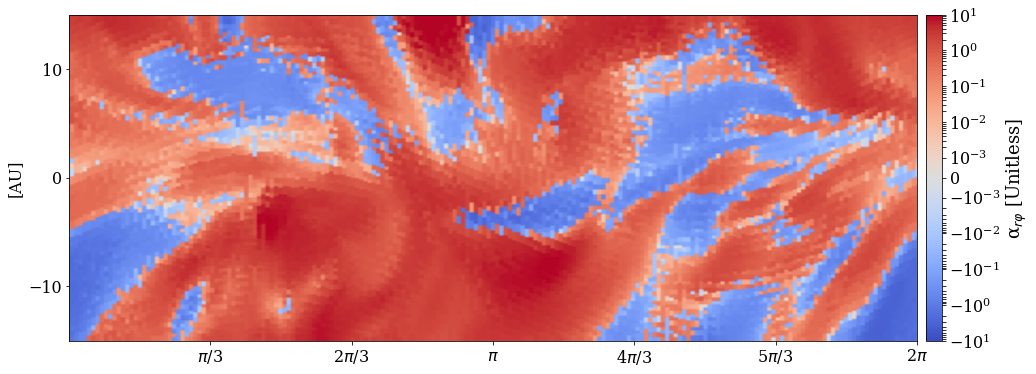

In [20]:
tick_labels = ['$\pi$/3','2$\pi$/3','$\pi$', '4$\pi$/3', '5$\pi$/3', '2$\pi$']
tick_values = [np.pi/3, 2*np.pi/3, np.pi, np.pi/3 + np.pi, 2*np.pi/3 + np.pi, 2*np.pi]

fig, ax = plt.subplots(figsize = (16,6))
ax.set(ylabel = '[AU]', xlim = (0, 2*np.pi)); ax.set_xticks(tick_values); ax.set_xticklabels(tick_labels);
ytick = radius * data.au_length // 2
ax.set_yticks([-ytick,0, ytick]);

cmap = ax.pcolormesh(phinew_grid, znew_grid * data.au_length, total_Ir.T, norm = colors.SymLogNorm(linthresh=1e-3, linscale=0.5, vmin = -1e1, vmax = 1e1), snap = True, shading = 'gouraud', cmap = 'coolwarm')
cbar = fig.colorbar(cmap, ax=ax, fraction = 0.04, pad = 0.01)
cbar.set_label('α$_{rφ}$ [Unitless]',fontsize = 18)